# MEAP implementation of RETROICOR

MEAP versions 1.5.2 and higher have a working implementation of RETROICOR. In order for it to work with your data a few things are required

1. A ``fmri_triggers`` channel in your ``mea.mat`` file
2. Accurately identified QRS complexes
3. The slice times
4. The direction in which your slices were acquired
5. A 4D NIfTI file containing your BOLD signal
6. A 3D binary mask identifying brain voxels

There are a couple important notes on some of these.

### Slice timing conventions

The slice timings should be specified in a text file that is readable by numpy.loadtxt. If you provide a file with any times larger than 10, it is assumed that the timings are in milliseconds. Otherwise seconds is assumed. Another slice timing convention is to provide values in the range of -0.5 to 0.5, where 0 is the midpoint of the TR and the values represent proportions of the TR. Here is an example text file from a 64-slice Coronal multiband EPI scan that will work:

```
0.50000
0.07418
-0.35440
0.19505
-0.23352
0.31868
-0.10989
0.43956
0.01099
-0.41484
0.13462
-0.29396
0.25549
-0.17033
0.37912
-0.04945
0.50000
0.07418
-0.35440
0.19505
-0.23352
0.31868
-0.10989
0.43956
0.01099
-0.41484
0.13462
-0.29396
0.25549
-0.17033
0.37912
-0.04945
0.50000
0.07418
-0.35440
0.19505
-0.23352
0.31868
-0.10989
0.43956
0.01099
-0.41484
0.13462
-0.29396
0.25549
-0.17033
0.37912
-0.04945
0.50000
0.07418
-0.35440
0.19505
-0.23352
0.31868
-0.10989
0.43956
0.01099
-0.41484
0.13462
-0.29396
0.25549
-0.17033
0.37912
-0.04945
```

### Acquisition direction

The acquisition direction describes the direction in which your slices were acquired. If you used an axial acquisition, values can be "I" or "S" ("I" from the top down, "S" from the bottom up). Coronal slices can have values "A" or "P" ("A" from the posterior to anterior, "P" from anterior to posterior). Sagittal slicing can be "R" or "L" ("R" from left to right, "L" from right to left). **This must be the direction USED BY THE SCANNER, not the NIfTI affine**. 

The NIfTI can be oriented in any direction as long as the first dimension is left and right, the second dimension is anterior and postior, the third dimension is inferior and superior and the fourth dimension is time. It doesn't matter which direction the NIfTI is oriented as long as the dimensions are in that order. This is also true for the 3D binary mask.

In case you can't find the DICOM field that describes the slice acquisition direction, you can check the "Unsure about direction" checkbox and the correction will be run once in each direction. If you don't know what plane the slices were acquired in, you're out of luck.

### Accurate QRS complex identification is important

RETROICOR depends on accurate QRS complex identification. The model is built on the assumption that the phase of the cardiac cycle at which the slice was acquired will affect the signal. If a QRS complex is missed or mislabeled, it will degrade the model fit and reduce the efficacy of the RETROICOR correction.  It would not be a bad idea to manually inspect the QRS identification in your data. fMRI ECG can be very tricky sometimes.

### Running from the GUI

This entire pipeline can be run from the MEAP Pipeline interface. For illustrative purposes we will use the MEAP API to show what happens at each step of the process.

## RETROICOR walkthrough

The MEAP implementation is based on the Glover and Ress paper and was checked against the PhysIO toolbox and another toolbox from NYU. Data used here is from a study at UCSB.

First, load the preprocessed MEAP file and do a quality inspection on HR. 

Populating the interactive namespace from numpy and matplotlib


05/09/2018 12:47:13 PM loading event data EVENT_Photodiode


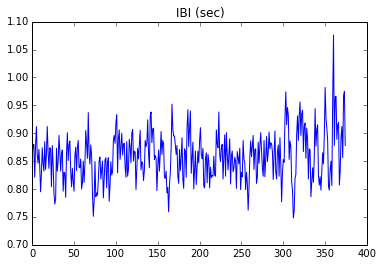

In [1]:
%pylab inline
import numpy as np
import nibabel as nib
from meap.io import load_from_disk # loads mea.mat files
from meap.physio_regressors import FMRITool # This is the RETROICOR class
phys = load_from_disk("127_b6_HE.mea.mat")
plot(np.diff(phys.peak_times))
title("IBI (sec)");

these are times in seconds between QRS complexes. Overall this looks plausible. Now, check that the fmri triggers are consistent:

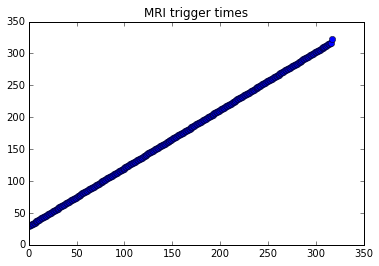

In [2]:
plot(phys.mri_trigger_times, 'bo')
title("MRI trigger times");

We can see that there is an additional trigger time at the end. Take note of this. Now, set up the fMRI data. Here we load it and check that everything is oriented correctly:

In [3]:
fmri_img = nib.load("alison_LPS+.nii.gz")
fmri_img.affine

array([[  -3.        ,   -0.        ,   -0.        ,   85.98872375],
       [  -0.        ,   -3.        ,   -0.        ,  110.3585434 ],
       [   0.        ,    0.        ,    3.        ,  -98.79882812],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

Note that there are non-zero values along the diagonal. This is necessary. If your data does not have this feature, you can re-orient it using AFNI's ``3dresample`` program. The mask image is in the same space

In [4]:
mask_img = nib.load("alison_mask.nii.gz")
mask_img.affine

array([[  -3.        ,   -0.        ,   -0.        ,   85.98872375],
       [  -0.        ,   -3.        ,   -0.        ,  110.3585434 ],
       [   0.        ,    0.        ,    3.        ,  -98.79882812],
       [   0.        ,    0.        ,    0.        ,    1.        ]])

We know from the DICOM headers that the slices were acquired from anterior to posterior (+LPH). With this information we can run the whole analysis. Here the FMRITool is constructed:

In [5]:
ricor_model = FMRITool(physiodata=phys)
ricor_model.slice_times_txt = "s127_APAV6slicet.txt"
ricor_model.acquisition_type = "Coronal"
ricor_model.dicom_acquisition_direction = "LPS+"
ricor_model.fmri_file = "alison_LPS+.nii.gz"
ricor_model.fmri_mask = "alison_mask.nii.gz"
ricor_model.nuisance_output_prefix = "test_nuisance"
ricor_model.unsure_about_direction = True

05/09/2018 12:47:13 PM More triggers in physiodata than volumes in fmri file


Note the warning that there are more triggers in the physiodata file than in the MRI. This is due to the strange extra trigger that was picked up after scanning had completed. 

### Calculating the RETROICOR regressors

All voxels in the same slice will have been sampled at the same phase of the cardiac cycle. We therefore need to generate a separate model for each slice. The following code comes from the ``FMRITool._b_calculate_fired`` function, which is run when the user clicks the **RUN** button. It is adapted below to run outside of the class. NOTE: you do not need to use this code to process your own data. It is just for illustration

In [6]:
ricor_model._load_slice_timings()
n_trs = len(ricor_model.tr_onsets)

ricor_model.slice_times_matrix = np.row_stack([ricor_model.slice_times] * n_trs)
slice_regressors = ricor_model.compute_slicewise_regressors()

print "computed", len(slice_regressors), "unique noise models"
        

05/09/2018 12:47:13 PM Using the mid-TR slice convention
05/09/2018 12:47:13 PM Assuming slice timings are in seconds
05/09/2018 12:47:13 PM Using slice timings of [ 0.91000003  0.52250382  0.132496    0.63249552  0.24249681  0.74499882
  0.35500011  0.85499962  0.46500091  0.0774956   0.57750422  0.18749641
  0.68749592  0.29999971  0.79999922  0.41000051  0.91000003  0.52250382
  0.132496    0.63249552  0.24249681  0.74499882  0.35500011  0.85499962
  0.46500091  0.0774956   0.57750422  0.18749641  0.68749592  0.29999971
  0.79999922  0.41000051  0.91000003  0.52250382  0.132496    0.63249552
  0.24249681  0.74499882  0.35500011  0.85499962  0.46500091  0.0774956
  0.57750422  0.18749641  0.68749592  0.29999971  0.79999922  0.41000051
  0.91000003  0.52250382  0.132496    0.63249552  0.24249681  0.74499882
  0.35500011  0.85499962  0.46500091  0.0774956   0.57750422  0.18749641
  0.68749592  0.29999971  0.79999922  0.41000051]
05/09/2018 12:47:13 PM Computing regressors for slice 0
0

computed 64 unique noise models


We see that there are 64 noise models computed here. "Unique" might be misleading here because in a multiband sequence, each is acquired along with a number of other slices simultaneously (therefore were acquired at the same phase of the cardiac cycle and will have identical noise models). Let's examine each of these noise models. They are pandas dataframe objects

In [7]:
slice10 = slice_regressors[9]
slice10.head()

,poly00,poly01,poly02,poly03,poly04,poly05,resp_ricor_cos1,resp_ricor_sin1,resp_ricor_cos2,resp_ricor_sin2,...,cardiac_ricor_cos1,cardiac_ricor_sin1,cardiac_ricor_cos2,cardiac_ricor_sin2,cardiac_ricor_cos3,cardiac_ricor_sin3,ix_plus_ricor_cos1,ix_plus_ricor_sin1,ix_minus_ricor_cos1,ix_minus_ricor_sin1
0,1,-1.000000,1.000000,-1.000000,1.000000,-1.000000,-0.961416,-0.275097,0.848643,0.528966,...,-0.412447,0.910981,-0.659774,-0.751464,0.956692,-0.291103,0.647142,-0.762369,0.145925,-0.989296
1,1,-0.993631,0.980953,-0.962087,0.937214,-0.906570,0.397352,-0.917666,-0.684222,-0.729274,...,-0.796408,0.604760,0.268531,-0.963271,0.368688,0.929553,0.238513,0.971139,-0.871422,-0.490534
2,1,-0.987261,0.962027,-0.924779,0.876227,-0.817293,0.317013,0.948421,-0.799006,0.601323,...,-0.946017,0.324118,0.789895,-0.613243,-0.548490,0.836157,-0.607300,-0.794473,0.007501,0.999972
3,1,-0.980892,0.943223,-0.888071,0.817011,-0.732062,-0.769429,-0.638733,0.184041,0.982919,...,-0.969643,-0.244525,0.880415,0.474205,-0.737733,-0.675093,0.589884,0.807488,0.902257,-0.431198
4,1,-0.974522,0.924541,-0.851961,0.759540,-0.650772,0.577019,-0.816731,-0.334098,-0.942538,...,-0.564300,-0.825570,-0.363130,0.931738,0.974129,-0.225991,-0.999880,-0.015488,0.348656,-0.937251


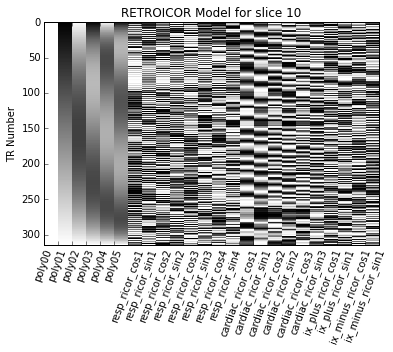

In [8]:
fig,ax = plt.subplots()
ax.imshow(slice10,interpolation="nearest",aspect="auto", cmap="gray")
columns = slice10.columns
ax.set_xticks(np.arange(len(columns)) - 0.5)
ax.set_xticklabels(columns)
ax.set_title("RETROICOR Model for slice 10")
ax.set_ylabel("TR Number")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 );

This noise model was created based on four parameters: the cardiac, respiratory and interaction expansion orders and the polynomial expansion order of the drift model. The column names show what noise signal the model is based on (poly: signal drift polynomials, resp: respiration, cardiac: cardiac phase, ix: cardiac/respiratory interaction). Each order is expanded with a sine and cosine, each with $n^{\text{th}}$ order harmonics. The expansion order defaults (used here) were determined to be optimal in 2008. These can be changed in the GUI or through the API.

We can also see that the regressors change at each slice:

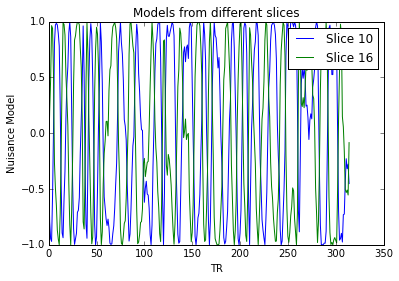

In [9]:
slice16 = slice_regressors[15]
plot(slice10.cardiac_ricor_cos1, label="Slice 10")
plot(slice16.cardiac_ricor_cos1, label="Slice 16")
xlabel("TR")
ylabel("Nuisance Model")
legend()
title("Models from different slices");

### Double-checking the slice order

Under the hood, MEAP uses the provided BOLD mask to number each voxel according to which slice number the voxel is in. Here is how that looks

05/09/2018 12:47:59 PM Slice acquisition consistent with voxel order in y axis


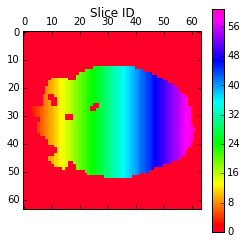

In [10]:
from meap.physio_regressors import get_slicenum_volume
slicenums = mask_img.get_data() * get_slicenum_volume(
                mask_img.shape, mask_img.affine, "Coronal", "LPS+")
matshow(slicenums[:,:,32], cmap="gist_rainbow"); colorbar(); title("Slice ID");

This is the correct behavior. The numbers on the axis reflect index into the 3D matrix. This is the middle slice in the z direction. The brain is oriented so that matrix indices increase towards the posterior (consistent with the negative value in the affine at 1,1). The colors correspond to each row in the slice times matrix. We could replace these numbers with the actual slice timings:

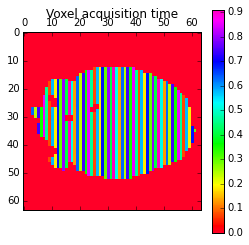

In [11]:
slicetimes_vol = ricor_model.slice_times[
    slicenums.flatten().astype(np.int)].reshape(mask_img.shape) * mask_img.get_data()
matshow(slicetimes_vol[:,:,32],cmap="gist_rainbow"); colorbar(); title("Voxel acquisition time");

Now the multiband structure is apparent. 

## Fitting the RETROICOR model

The function ``FMRITool.process_mri_slices`` is adapted for illustrative purposes below. Again, this code does not need to be copied to run this analysis in practice.

In [12]:
from sklearn.linear_model import LinearRegression

# Load the bold data
_img = nib.load(ricor_model.fmri_file)
img = _img.get_data()
_mask = nib.load(ricor_model.fmri_mask)
mask = _mask.get_data()

# Make a volume where each voxel contains its slice number
slices = np.zeros(mask.shape)
nslices = mask.shape[0]

slices = get_slicenum_volume(_mask.shape, _mask.affine,
            ricor_model.acquisition_type, ricor_model.dicom_acquisition_direction)

# Create a matrix of timeseries. also get a corresponding array of slice numbers
ts = img[mask>0]
slicenum = slices[mask>0].astype(np.int)

# sometimes a trigger is sent before the scan is cancelled.
design_len = np.array([x.shape[0] for x in slice_regressors])
assert np.all(design_len == design_len[0])
design_len = design_len[0]
nvols = ts.shape[1]
if nvols < design_len:
    for nslice in range(nslices):
        slice_regressors[nslice] = slice_regressors[nslice][:nvols]
elif nvols > design_len:
    ts = ts[:,:design_len]

# Holds the corrected output
retroicorrected = np.zeros(ts.shape,dtype=np.float)

# Holds a nuisance timeseries for all modalities
fitts = np.zeros_like(retroicorrected)

# Compute the fits
reg = LinearRegression(fit_intercept=False, normalize=False)
voxel_fits = np.zeros(ts.shape[0]) # holds the r^2

# Get the models as matrices
design_mats = [x.as_matrix() for x in slice_regressors]
# Make masks for different coefficient types
columns = slice_regressors[0].columns # These are always the same
resp_mask = np.array([col.startswith("resp") for col in columns])
cardiac_mask = np.array([col.startswith("cardiac") for col in columns])
ix_mask = np.array([col.startswith("ix") for col in columns])
detrend_mask = np.array([col.startswith("poly") for col in columns])
ricor_mask = ix_mask | cardiac_mask | resp_mask

ricor_model.output_units = "Percent Signal Change"
if ricor_model.output_units == "Percent Signal Change":
    ts_mean = ts.mean(axis=1)
    ts = (ts - ts_mean[:,None]) / ts_mean[:,None] * 100

for nvox, voxel in enumerate(ts):
    if nvox % 10000 == 0 : print nvox
    # Get the design specific for this slice
    whole_design = design_mats[slicenum[nvox]]
    reg.fit(whole_design, voxel)
    
    # Get an r^2 for the retroicor model after subtracting the drift fits
    voxel_fits[nvox] = reg.score(whole_design, voxel)
    retroicorrected[nvox] = reg.predict(whole_design)

    if ricor_model.write_4d_nuisance:
        fitts[nvox] = np.dot(whole_design, reg.coef_)

05/09/2018 12:48:02 PM Slice acquisition consistent with voxel order in y axis


0
10000
20000
30000
40000
50000


What does this look like for a specific voxel? Here we double-dip and choose the voxel with the highest $r^2$ and walk through the code.

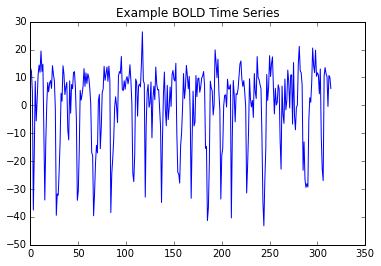

In [13]:
nvox = np.argmax(voxel_fits)
voxel = ts[nvox]
plot(voxel)
title("Example BOLD Time Series");

and the corresponding noise model

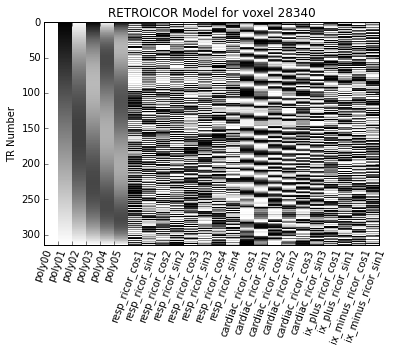

In [14]:
whole_design = design_mats[slicenum[nvox]]
fig,ax = plt.subplots()
ax.imshow(whole_design,interpolation="nearest",aspect="auto", cmap="gray")
columns = slice10.columns
ax.set_xticks(np.arange(len(columns)) - 0.5)
ax.set_xticklabels(columns)
ax.set_title("RETROICOR Model for voxel %d" % nvox)
ax.set_ylabel("TR Number")
plt.setp( ax.xaxis.get_majorticklabels(), rotation=70 );

Now fit the model with the actual voxel data

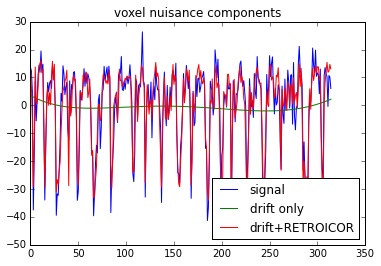

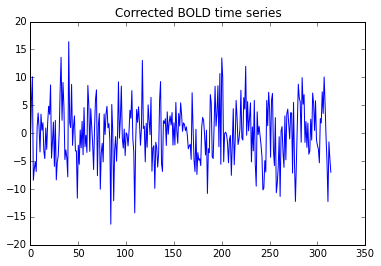

In [15]:
reg = LinearRegression(fit_intercept=False, normalize=False)
reg.fit(whole_design, voxel)

# Get an r^2 for the retroicor model after subtracting the drift fits
r2_score = reg.score(whole_design, voxel)

intercept = reg.coef_[0] # the model intercept. Mean signal

corrected = voxel - reg.predict(whole_design)
drift_fit = np.dot(whole_design, reg.coef_ * detrend_mask)
ricor_fit = np.dot(whole_design, reg.coef_ * ricor_mask)

plot(voxel,label= "signal")
plot(drift_fit,label="drift only")
plot(drift_fit + ricor_fit, label="drift+RETROICOR")
legend(loc="lower right")
title("voxel nuisance components")
figure()
plot(voxel - drift_fit - ricor_fit)
title("Corrected BOLD time series");

The above code illustrates how some of the options in the MEAP RETROICOR GUI work. Here is the RETROICOR GUI for reference:

<img src="GUI.PNG">


### fMRI I/O

Fmri file is the path to the 4D EPI data. Fmri mask is the 3D volume that has nonzero values in brain voxels. Slice times txt is the path to the slice timing file. Acquisition type describes the axis along which slices were taken. Dicom acquisition direction is the direction (in world coordinates) in which slices were acquired. Unsure about direction runs the fitting with the slice timings and the slice timings reversed. This is useful if you're unsure about the direction of your slice timings. 

Denoised output is the path where the corrected signal will be written into a 4D NIfTI file. Nuisance output prefix is the beginning of the filenames where model fits of the nuisance models will be written. If "Write 4d nuisance for each modality" is checked, separate files will be written for the the cardiac regressors, the respiratory regressors, the interaction regressors and the drift regressors. In the code the whole model for voxel $i$ is fit at once:

$$ y_i(t) = \mathbf{\beta}X(t) + s(t) $$

where $s(t)$ is the de-noised BOLD signal at time $t$. If unchecked, a single 4D nuisance fit is saved that contains $\hat{\mathbf{\beta}}X(t)$ in each voxel. If this option is selected, the model is broken down into components

$$ y_i(t) = \beta_cX(t) + \beta_rX(t) \beta_{rc}X(t) + \beta_dX(t) + s(t) $$

where $\beta_r$ is the coefficients from fitting the whole model $X(t)$ with all but the respiration coefficients zeroed out. Similarly, $\beta_c$ contains non-zero estimates from cardiac regressors, $\beta_{cr}$ the interaction terms and $\beta_d$ the drift terms. In other words, after fitting the following relationship holds 

$$ \hat{\mathbf{\beta}} = \hat{\beta_c} + \hat{\beta_r} + \hat{\beta_{rc}} + \hat{\beta_d} $$

The filename specified in "Denoised output" contains $s(t)$ in each voxel. "Regression output" contains the $r^2$ value of the noise model in each voxel.

### RETROICOR

"Cardiac expansion order", "respiration expansion order" and "Interaction expansion order" determine how many harmonics to include in the noise model. "Drift model order" determines the number of Legendre polynomials to include for detrending. Specifying 0 will include only an intercept term. All higher numbers include that many columns with polynomials.

**Add back intensity** is an option that should be used if you want to perform motion correction on your BOLD data after running RETROICOR. These images will look like normal BOLD images. If not checked, the output time series will only contain differences from the intercept and no anatomical features will be shown.

If Percent Signal Change is the specified output unit, the "Add back intensity" option will have no effect. The values will be in BOLD intensities. 

### Writing output files

This is how MEAP writes out the results in NIfTI format

In [16]:
# write the output
def save_scalars(vec,filename):
    new_data = np.zeros_like(mask,dtype=np.float32)
    new_data[mask>0] = vec
    nib.Nifti1Image(new_data,_mask.get_affine()#,
            #header=_mask.get_header()).to_filename(filename)
            ).to_filename(filename)

# write the output
def save_vectors(vec,filename):
    out_shape = list(_img.shape)
    new_data = np.zeros(out_shape, dtype=np.float32)
    new_data[mask>0] = vec
    nib.Nifti1Image(new_data, _img.get_affine()
            #header=_img.get_header()).to_filename(filename)
            ).to_filename(filename)

save_scalars(voxel_fits, ricor_model.regression_output)
save_vectors(retroicorrected, ricor_model.denoised_output)

Examining the output:

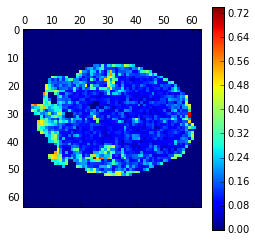

In [17]:
r2img = nib.load(ricor_model.regression_output)
matshow(r2img.get_data()[:,:,32]); colorbar();

This looks correct. There are very high fits in the insula and frontal sinus areas. Now load the 4D timeseries output to see how it looks:

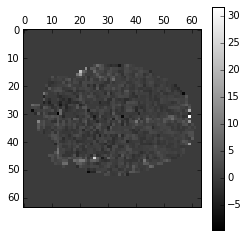

In [18]:
img4d = nib.load(ricor_model.denoised_output)
data4d = img4d.get_data()
matshow(data4d[:,:,32,0],cmap="gray"); colorbar();

Note that the anatomical features are gone and the values are not in the high thousands like regular BOLD values. These are in percent signal change.